In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import numpy as np
import random
from tqdm import tqdm

import sys, os
sys.path.append(os.path.abspath(".."))  

from vae.utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Standard Autoencoder using MLP

### EMNIST Dataset

In [33]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds = torchvision.datasets.EMNIST('../data/', train=True, download=True, split='balanced',
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Resize((img_size,img_size)),
                                          torchvision.transforms.ToTensor(), # creating tensors
                                          torchvision.transforms.Lambda(lambda x: x.transpose(1, 2)),
                                          torchvision.transforms.Lambda((lambda x: torch.flatten(x).to(device))), # Tensor([784])
                            ]))
label_mapping = ds.class_to_idx

x.shape: torch.Size([784])
type(t): <class 'int'>


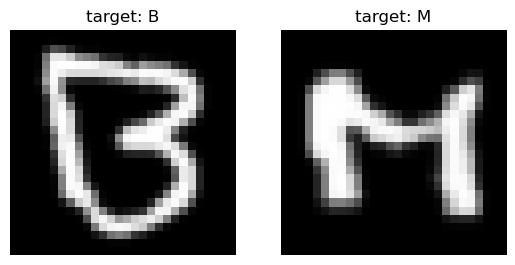

In [24]:
i, j = random.randint(0, 1024), random.randint(0, 1024)
x1,t1 = ds.__getitem__(i)
x2, t2 = ds.__getitem__(j)

print(f"x.shape: {x1.shape}")
print(f"type(t): {type(t1)}")

plt.subplot(1, 2, 1)

draw(x1, f"target: {convert_i2c(t1)}")

plt.subplot(1, 2, 2)
draw(x2, f"target: {convert_i2c(t2)}")
plt.show()

In [25]:
batch_size = 64
ds = torch.utils.data.Subset(ds, range(5000))
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

### Training Autoencoder with MLP

In [58]:
class AutoEncoder(nn.Module): 
    def __init__(self, in_dim, latent_dim, loss_fcn=nn.MSELoss()): 
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.loss_fcn = loss_fcn
        self.losses = []

        self.encoder = nn.Sequential(
            nn.Linear(self.in_dim, 300), nn.ReLU(), 
            nn.Linear(300, 200), nn.ReLU(), 
            nn.Linear(200, self.latent_dim), nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 200), nn.ReLU(),
            nn.Linear(200, 100), nn.ReLU(),
            nn.Linear(100, self.in_dim), nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def learn(self, dl, epochs=10, lr=0.001):
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x_batch, t_batch in dl: 
                y_batch = self.forward(x_batch) 
                loss = self.loss_fcn(y_batch, x_batch) # Reconstruction Loss (MSE)
                # backprop
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                # loss in the epoch
                total_loss += loss.item()*len(x_batch) 
                
            self.losses.append(total_loss/len(dl.dataset)) 
        plt.plot(self.losses); plt.xlabel('Epochs');
        plt.yscale('log');
                
        

100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


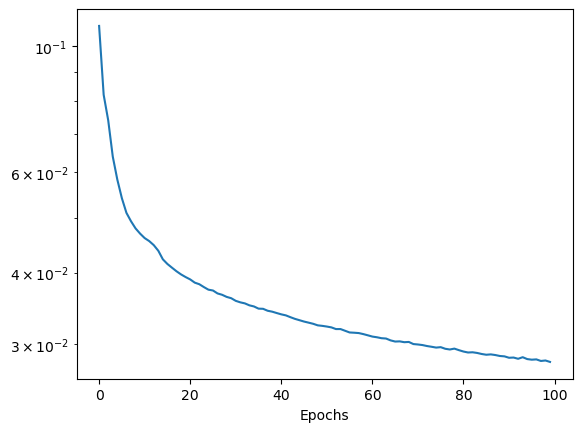

In [64]:
latent_dim = 16
epochs = 100
lr = 0.001 
ae = AutoEncoder(in_dim=img_size**2, latent_dim=latent_dim)
ae.learn(dl, epochs=epochs, lr=lr)

In [ ]:
# Save model
model_name = f"../models/ae_mlp_(epochs={epochs})_(lr={lr})_(latent_dim={latent_dim}).pth"
torch.save(ae, model_name)

### Reconstructing Images using Trained Autoencoder

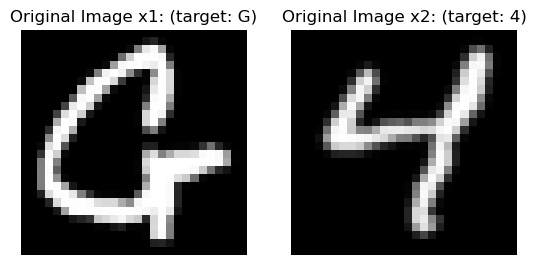

In [66]:
idx1 = random.randint(0, 3204)
x1, t1 = ds.__getitem__(idx1)

idx2 = random.randint(0, 3204)
x2, t2 = ds.__getitem__(idx2)

plt.subplot(1,2, 1)
draw(x1, f"Original Image x1: (target: {convert_i2c(t1)})")
plt.subplot(1,2, 2)

draw(x2, f"Original Image x2: (target: {convert_i2c(t2)})")

In [67]:
# Encoding inputs
z1 = ae.encoder(x1)
z2 = ae.encoder(x2)

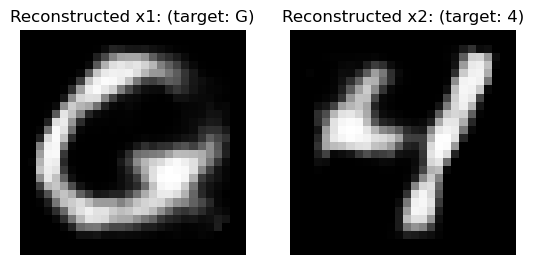

In [68]:
y1 = ae.decoder(z1)
y1 = y1.squeeze(0)
plt.subplot(1,2,1)
draw(y1, f"Reconstructed x1: (target: {convert_i2c(t1)})")

y2 = ae.decoder(z2)
y2 = y2.squeeze(0)
plt.subplot(1,2,2)
draw(y2, f"Reconstructed x2: (target: {convert_i2c(t2)})")